# 1. Import Libraries 

In [1]:
import glob
import time
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
pd.set_option('display.max_columns', None)

import cv2

import Utility_functions as ut
import Custom_Evaluation as ce

#PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms

#Skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring,ProgressBar, Checkpoint
from skorch.dataset import CVSplit, ValidSplit
from skorch.callbacks import TrainEndCheckpoint
from torch.utils.data import TensorDataset, DataLoader

#model performance
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,top_k_accuracy_score, balanced_accuracy_score, f1_score, recall_score 

#Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

#Distnce Matrix
from scipy.spatial import distance_matrix, distance
from scipy.special import softmax

#Supress warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

from sklearn.manifold import TSNE

import argparse
import optuna
from optuna.integration import SkorchPruningCallback

data_dir = 'C:/Dissertation/Data/'

In [2]:
%load_ext autoreload
%autoreload 2

# 2. Import Data

In [3]:
Final_Images_df, predicate_df = ut.AWA2DataLoader(data_dir, data_type = "ResNet101-Features", 
                                                  Resnet101Type = 1, 
                                                  animal_attributes = 'AwA2', 
                                                  VectorType = 'Binary')

#data_type options
#1. "ResNet101-Features" to load Extracted Resnet101 features Avg. Time - 12 secs
#2. "Images"

#Resnet101Type
# 1 - Using Resnet Features provided with data
# 2 - Using Resnet Features extracted by Abhimanyu Acharya using a pretrainied Resnet101

# animal_attribute
#1. "AwA2" - As provided with AwA2 data
#2. "Custom Animal Attribute KG" - Custom KGs
#3. "Custom Animal Attribute + Taxonomy KG" - Custom KGs
#4. "Word2Vec" - word2vec-google-news-300
#5. "Dbnary" - Dbnary Knowledge Graph/Wiktionary (KGVec2Go Wiktionary/DBnary)
#6. "DBpedia" - DBPedia Knowledge Graph (KGVec2Go Classic RDF2vec: 500 walks, depth: 4, SG, 200 dimensions)

Using Resnet101 Features provided with data
Animal Attributes Included - Binary Vector
Execution time: 10.539851903915405 seconds


# 3. Split Data in Predefined Test, Train & Validation for ZSL

In [4]:
trainval_df, TrainData01, ValData01, TrainData02, ValData02, TrainData03, ValData03, Seen_test_df, Unseen_test_df = ut.TestTrainValsplitdata_dir(data_dir, Final_Images_df)

  Training - Validation Split 01 
 Train Classes  
 Number of Classes 27 
 ['antelope' 'buffalo' 'chihuahua' 'collie' 'cow' 'elephant' 'fox'
 'german+shepherd' 'grizzly+bear' 'hippopotamus' 'humpback+whale'
 'killer+whale' 'lion' 'mouse' 'otter' 'persian+cat' 'pig' 'polar+bear'
 'rhinoceros' 'siamese+cat' 'skunk' 'spider+monkey' 'squirrel' 'tiger'
 'weasel' 'wolf' 'zebra'] 

 Validation Classes  
 Number of Classes 13 
 ['beaver' 'chimpanzee' 'dalmatian' 'deer' 'giant+panda' 'gorilla'
 'hamster' 'leopard' 'mole' 'moose' 'ox' 'rabbit' 'raccoon'] 

  Training - Validation Split 02 
 Train Classes  
 Number of Classes 27 
 ['buffalo' 'chimpanzee' 'collie' 'cow' 'deer' 'elephant' 'german+shepherd'
 'giant+panda' 'gorilla' 'hamster' 'hippopotamus' 'humpback+whale'
 'leopard' 'lion' 'mole' 'moose' 'mouse' 'polar+bear' 'rabbit' 'raccoon'
 'rhinoceros' 'siamese+cat' 'spider+monkey' 'squirrel' 'tiger' 'weasel'
 'wolf'] 

 Validation Classes  
 Number of Classes 13 
 ['antelope' 'beaver' 'chihua

# 4. Define Dependent and Independent variables 

In [5]:
# Pre defined Test split 01
X1 = TrainData01.iloc[:,1:2049]
y1 = TrainData01.iloc[:,2051:2136]

# Pre defined Test split 02
X2 = TrainData02.iloc[:,1:2049]
y2 = TrainData02.iloc[:,2051:2136]

# Pre defined Test split 03
X3 = TrainData03.iloc[:,1:2049]
y3 = TrainData03.iloc[:,2051:2136]

X_finaltrain = trainval_df.iloc[:,1:2049]
y_finaltrain = trainval_df.iloc[:,2051:2136]

In [6]:
#Train val split for testing projection network
X_train1,X_val_seen_classes1,y_train1,y_val_seen_classes1 = train_test_split(X1,y1,stratify=y1,test_size=0.1,random_state = 0)

X_train2,X_val_seen_classes2,y_train2,y_val_seen_classes2 = train_test_split(X2,y2,stratify=y2,test_size=0.1,random_state = 0)

X_train3,X_val_seen_classes3,y_train3,y_val_seen_classes3 = train_test_split(X3,y3,stratify=y3,test_size=0.1,random_state = 0)

#Stratify Final train data 
X_train_final,X_val_seen_classes_final,y_train_final,y_val_seen_classes_final = train_test_split(X_finaltrain,y_finaltrain,stratify=y_finaltrain,test_size=0.002,random_state = 0)

# 5. Define Animal Attributes

In [7]:
animal_attributes_df = pd.read_csv("C:/Dissertation/Data/AwA2-data/Animals_with_Attributes2/predicates.txt", sep = '\t',header = None, names = ['predicates'])
animal_attributes_list = animal_attributes_df['predicates'].tolist()
print(animal_attributes_list)

['black', 'white', 'blue', 'brown', 'gray', 'orange', 'red', 'yellow', 'patches', 'spots', 'stripes', 'furry', 'hairless', 'toughskin', 'big', 'small', 'bulbous', 'lean', 'flippers', 'hands', 'hooves', 'pads', 'paws', 'longleg', 'longneck', 'tail', 'chewteeth', 'meatteeth', 'buckteeth', 'strainteeth', 'horns', 'claws', 'tusks', 'smelly', 'flys', 'hops', 'swims', 'tunnels', 'walks', 'fast', 'slow', 'strong', 'weak', 'muscle', 'bipedal', 'quadrapedal', 'active', 'inactive', 'nocturnal', 'hibernate', 'agility', 'fish', 'meat', 'plankton', 'vegetation', 'insects', 'forager', 'grazer', 'hunter', 'scavenger', 'skimmer', 'stalker', 'newworld', 'oldworld', 'arctic', 'coastal', 'desert', 'bush', 'plains', 'forest', 'fields', 'jungle', 'mountains', 'ocean', 'ground', 'water', 'tree', 'cave', 'fierce', 'timid', 'smart', 'group', 'solitary', 'nestspot', 'domestic']


# 6. Load Taxonomy Information

In [8]:
taxonomy_df = pd.read_csv("C:/Dissertation/Data/Mammal Taxonomy/Mammal Taxonomy_noduplicates.csv")
taxonomy_df.drop(['subgenus','biogeographicRealm','CMW_sciName'], axis = 1, inplace = True)
taxonomy_df.head()

,sciName,animal_label,animal_class,mainCommonName,otherCommonNames,class,infraclass,magnorder,superorder,order,suborder,infraorder,parvorder,superfamily,family,subfamily,tribe,genus
0,Antilope_cervicapra,1,antelope,Blackbuck,Indian Antelope,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,ARTIODACTYLA,RUMINANTIA,PECORA,NaN,NaN,BOVIDAE,ANTILOPINAE,ANTILOPINI,Antilope
1,Ursus_arctos,2,grizzly+bear,Brown Bear,Grizzly Bear|Kodiak Bear,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,CARNIVORA,CANIFORMIA,ARCTOIDEA,NaN,URSOIDEA,URSIDAE,URSINAE,NaN,Ursus
2,Orcinus_orca,3,killer+whale,Killer Whale,Orca,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,ARTIODACTYLA,WHIPPOMORPHA,CETACEA,ODONTOCETI,DELPHINOIDEA,DELPHINIDAE,INCERTAE SEDIS,NaN,Orcinus
3,Aplodontia_rufa,4,beaver,Mountain Beaver,Boomer|Sewellel|Point Arena Mountain Beaver|Po...,Mammalia,Placentalia,Boreoeutheria,Euarchontoglires,RODENTIA,SCIUROMORPHA,NaN,NaN,NaN,APLODONTIIDAE,NaN,NaN,Aplodontia
4,Canis_familiaris,5,dalmatian,Domestic Dog,Dog|Dingo|Feral Dog|New Guinea Singing Dog|Vil...,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,CARNIVORA,CANIFORMIA,CANOIDEA,NaN,NaN,CANIDAE,NaN,NaN,Canis


# 7. Set up Neural Network for multilabel classifciation

### 7.1 Define DNN for projection network

In [9]:
class ProjectionNetwork1(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork1, self).__init__()        
        self.fc1 = nn.Linear(2048, num_units)  
        self.fc2 = nn.Linear(num_units, 85) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out   

### 7.2 Define evaluation criterea and checkpoint for projection network

In [10]:
# Create Skorch EPOCHScoring   
train_macro_recall_score = EpochScoring(scoring='recall_macro', lower_is_better=False, name = 'train_recall_macro', on_train = True)
valid_macro_recall_score = EpochScoring(scoring='recall_macro', lower_is_better=False, name = 'valid_recall_macro', on_train = False)

# Create Checkpoint
CP1 = Checkpoint(monitor='valid_loss_best',dirname='exp1')
CP2 = Checkpoint(monitor='valid_loss_best',dirname='exp2')
CP3= Checkpoint(monitor='valid_loss_best',dirname='exp3')
CP_final= Checkpoint(monitor='valid_loss_best',dirname='exp_final')

### 7.3 Check for GPU

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.cuda.empty_cache()
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA GeForce RTX 3060 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# 8. Define Conventiona Zero Shot Leaning Function

In [16]:
def CZSL(mode, split, DNN, epochs, bs, numunits, lr, optimiser, dropout, mom, wd, device, checkpoint, pred_type, dist_type):
    torch.manual_seed(0)    
    
    if mode == "Train":
        if split == 1:
            X = X_train1.astype(np.float32).values
            y = y_train1.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes1
            SeenClassAttributes = y_val_seen_classes1
            UnseenData = ValData01
            
        if split == 2:
            X = X_train2.astype(np.float32).values
            y = y_train2.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes2
            SeenClassAttributes = y_val_seen_classes2
            UnseenData = ValData02
            
        if split == 3:
            X = X_train3.astype(np.float32).values
            y = y_train3.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes3
            SeenClassAttributes = y_val_seen_classes3
            UnseenData = ValData03
       
        
    if mode == "Test":
        X = X_train_final.astype(np.float32).values
        y = y_train_final.astype(np.float32).values        
        UnseenData = Unseen_test_df
    
    #Model 01
    net = NeuralNetClassifier(
    DNN,
    batch_size= bs,
    module__num_units = numunits,
    module__non_linear = optimiser,
    module__dropout = dropout,
    max_epochs=epochs,
    lr=lr,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = wd,
    train_split = ValidSplit(5),
    callbacks=[train_macro_recall_score,valid_macro_recall_score, checkpoint],
    callbacks__valid_acc=None,
    device= device,
    verbose=0
    )     
    
    #Train three models of three Train Val spilts
    print('Training DNN')
    st = time.time()   
    net.fit(X,y)
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')

    plt.show() 
    
    #load best model weights
    net.load_params(checkpoint=checkpoint)
       
    #predict attributes for Unseen classes 
    y_pred_unseen = net.predict(UnseenData.iloc[:,1:2049].astype(np.float32).values)
    y_pred_unseen_proba = net.predict_proba(UnseenData.iloc[:,1:2049].astype(np.float32).values)
    
    #limit search space to unseen classes 
    predicatedf_CZSL = predicate_df[predicate_df['classes'].isin((UnseenData.classes.unique()).tolist())]
    animal_attributes = np.array(predicatedf_CZSL.iloc[:,2:87])
    animal_attributes_labels = predicatedf_CZSL['labels'].unique()
    print('Unseen Class Labels')
    print(animal_attributes_labels)
    
    #Spatialise the unseen classes using TSNE
    print('TSNE spatialisation of Unseen Classes')
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseen_prob = []
    for y in y_pred_unseen_proba:
        y_pred_unseen_prob.append(y[1])
        
    if pred_type == 'Probabilistic':
        dist_CZSL= (1-distance.cdist(y_pred_unseen_prob, animal_attributes, dist_type))
    elif pred_type == 'Deterministic':    
        dist_CZSL= (1-distance.cdist(y_pred_unseen, animal_attributes, dist_type))
        
    CZSL_label_prediction = np.array([np.argmax(output) for output in dist_CZSL])
    
    #replace predicted labels with unseen class labels 
    if mode == "Train":
        CZSL_label_prediction = np.select([CZSL_label_prediction == 0, CZSL_label_prediction == 1, CZSL_label_prediction == 2, CZSL_label_prediction == 3
          , CZSL_label_prediction == 4, CZSL_label_prediction == 5, CZSL_label_prediction == 6, CZSL_label_prediction == 7
          , CZSL_label_prediction == 8, CZSL_label_prediction == 9, CZSL_label_prediction == 10, CZSL_label_prediction == 11
          , CZSL_label_prediction == 12], [animal_attributes_labels[0], animal_attributes_labels[1], animal_attributes_labels[2]
          , animal_attributes_labels[3], animal_attributes_labels[4], animal_attributes_labels[5]
          , animal_attributes_labels[6], animal_attributes_labels[7], animal_attributes_labels[8], animal_attributes_labels[9]
          , animal_attributes_labels[10], animal_attributes_labels[11], animal_attributes_labels[12]], CZSL_label_prediction)
    
    if mode == "Test":
        CZSL_label_prediction = np.select([CZSL_label_prediction == 0, CZSL_label_prediction == 1, CZSL_label_prediction == 2, CZSL_label_prediction == 3
          , CZSL_label_prediction == 4, CZSL_label_prediction == 5, CZSL_label_prediction == 6, CZSL_label_prediction == 7
          , CZSL_label_prediction == 8, CZSL_label_prediction == 9], [animal_attributes_labels[0], animal_attributes_labels[1], animal_attributes_labels[2]
          , animal_attributes_labels[3], animal_attributes_labels[4], animal_attributes_labels[5]
          , animal_attributes_labels[6], animal_attributes_labels[7], animal_attributes_labels[8], animal_attributes_labels[9]], CZSL_label_prediction)
        
     #sort class names 
    class_labels = UnseenData[['labels','classes', 'order', 'family']]
    class_labels.sort_values(by=['labels'], inplace=True)
    animal_classes = class_labels['classes'].unique()
    
    #Assess CZSL Model performance
    print(classification_report(UnseenData['labels'], CZSL_label_prediction, target_names = animal_classes))

    cm = confusion_matrix(UnseenData['labels'], CZSL_label_prediction, normalize = 'true')
    correct_predictions_perc = cm.diagonal()/cm.sum(axis=1)
    print("Top_1_accuracy for UnSeen Validation split 01 per class - " , correct_predictions_perc)
    print("Top_1_accuracy for UnSeen Validation split 01 - " , np.mean(correct_predictions_perc))

    # Visualize it as a heatmap
    plt.figure(figsize=(10,8))
    a = sns.heatmap(cm, annot=True, fmt='.1%', cmap='Reds',annot_kws={"size": 10} )
    label_font = {'size':'10'}  # Adjust to fit
    a.set_xlabel('Predicted labels', fontdict=label_font);
    a.set_ylabel('Observed labels', fontdict=label_font);
    a.set_yticklabels(animal_classes)
    a.set_xticklabels(animal_classes)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90) 
    plt.show()
    
    #predict taxonomy
    predicted_taxonomy_df = pd.DataFrame(CZSL_label_prediction, columns = ['pred_labels'])
    predicted_taxonomy_df = pd.merge(predicted_taxonomy_df, taxonomy_df,  how = 'left', left_on = 'pred_labels' , right_on = 'animal_label' )
    
    Train_family_labels = UnseenData.copy()
    Train_family_labels.sort_values(by=['order'], inplace=True)
    train_animal_family = Train_family_labels['order'].unique()
    
    print(classification_report(UnseenData['order'], predicted_taxonomy_df['order'], target_names=train_animal_family))
    
    cm = confusion_matrix(UnseenData['order'], predicted_taxonomy_df['order'])
    correct_predictions_perc = cm.diagonal()/cm.sum(axis=1)
    print("Top_1_accuracy for UnSeen Validation split 01 per class - " , correct_predictions_perc)
    print("Top_1_accuracy for UnSeen Validation split 01 - " , np.mean(correct_predictions_perc))

    # Visualize it as a heatmap
    plt.figure(figsize=(10,8))
    a = sns.heatmap(cm, annot=True, fmt='.1%', cmap='Reds',annot_kws={"size": 10} )
    label_font = {'size':'10'}  # Adjust to fit
    a.set_xlabel('Predicted labels', fontdict=label_font);
    a.set_ylabel('Observed labels', fontdict=label_font);
    a.set_yticklabels(train_animal_family)
    a.set_xticklabels(train_animal_family)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90) 
    plt.show()
    
    if mode == "Train":
        ce.per_class_top_k_accuracy_score(dist_CZSL, animal_attributes_labels, UnseenData, animal_classes, Train = True)
    if mode == "Test":
        ce.per_class_top_k_accuracy_score(dist_CZSL, animal_attributes_labels, UnseenData, animal_classes, Train = False)
        


# 9. Train Model

### 9.1 Train Validation Split 01

Using Deterministic predictions
Training DNN
Execution time: 150.5719518661499 seconds
Unseen Class Labels
[ 4  5 12 15 16 20 21 25 26 29 39 40 48]
TSNE spatialisation of Unseen Classes
              precision    recall  f1-score   support

      beaver       0.64      0.51      0.57       152
   dalmatian       0.35      0.50      0.41       442
        mole       0.05      0.72      0.09        75
     leopard       0.42      0.86      0.57       568
       moose       0.53      0.52      0.53       554
     gorilla       0.60      0.41      0.49       709
          ox       0.60      0.90      0.72       588
  chimpanzee       0.47      0.08      0.14       566
     hamster       0.68      0.61      0.64       640
      rabbit       0.29      0.01      0.03       877
 giant+panda       0.00      0.00      0.00       692
        deer       0.73      0.86      0.79      1069
     raccoon       0.60      0.56      0.58       408

    accuracy                           0.48      7340
  

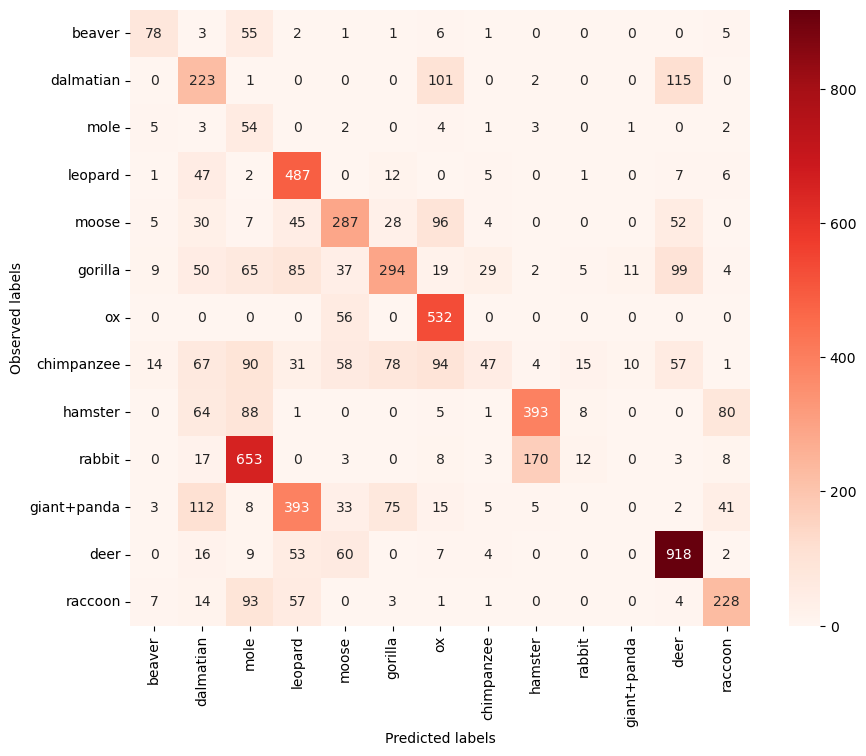

              precision    recall  f1-score   support

ARTIODACTYLA       0.75      0.91      0.82      2211
   CARNIVORA       0.73      0.76      0.75      2110
EULIPOTYPHLA       0.05      0.72      0.09        75
  LAGOMORPHA       0.29      0.01      0.03       877
    PRIMATES       0.76      0.35      0.48      1275
    RODENTIA       0.67      0.59      0.63       792

    accuracy                           0.63      7340
   macro avg       0.54      0.56      0.47      7340
weighted avg       0.68      0.63      0.62      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.90818634 0.76208531 0.72       0.01368301 0.35137255 0.59469697]
Top_1_accuracy for UnSeen Validation split 01 -  0.5583373630096449


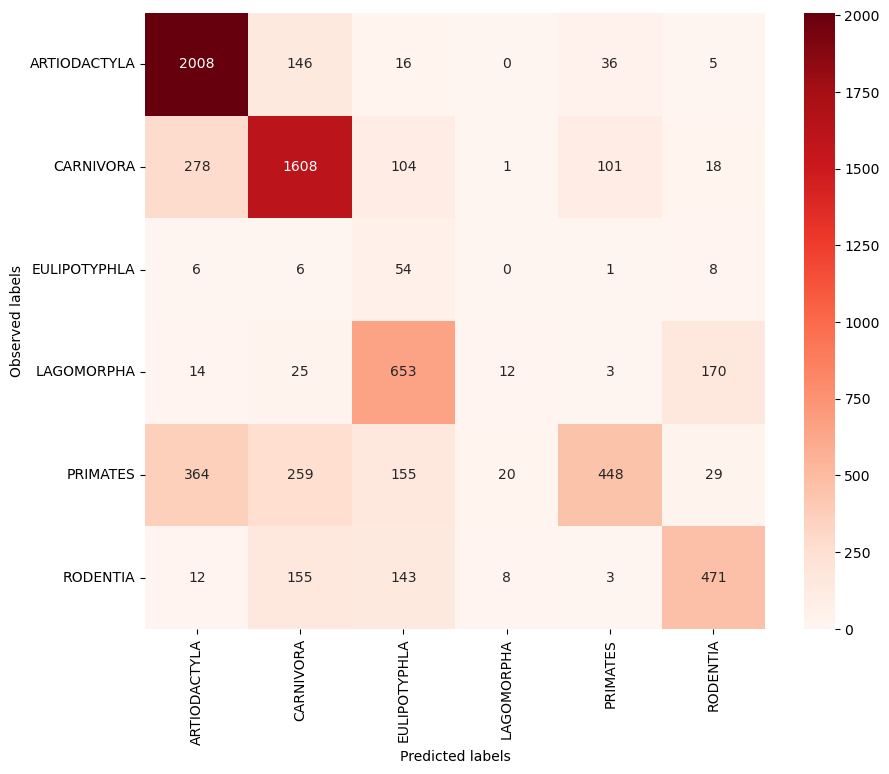

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6504875653212625 
              0         1
0        beaver  0.611842
1     dalmatian  0.660633
2          mole  0.813333
3       leopard  0.934859
4         moose  0.772563
5       gorilla  0.610719
6            ox  1.000000
7    chimpanzee  0.284452
8       hamster  0.815625
9        rabbit  0.153934
10  giant+panda  0.002890
11         deer  0.920486
12      raccoon  0.875000 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7399928210201915 
              0         1
0        beaver  0.750000
1     dalmatian  0.850679
2          mole  0.853333
3       leopard  0.959507
4         moose  0.823105
5       gorilla  0.726375
6            ox  1.000000
7    chimpanzee  0.501767
8       hamster  0.948438
9        rabbit  0.291904
10  giant+panda  0.013006
11         deer  0.972872
12      raccoon  0.928922 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.8438023863950311 
              0         1
0        beaver  0.828947
1     

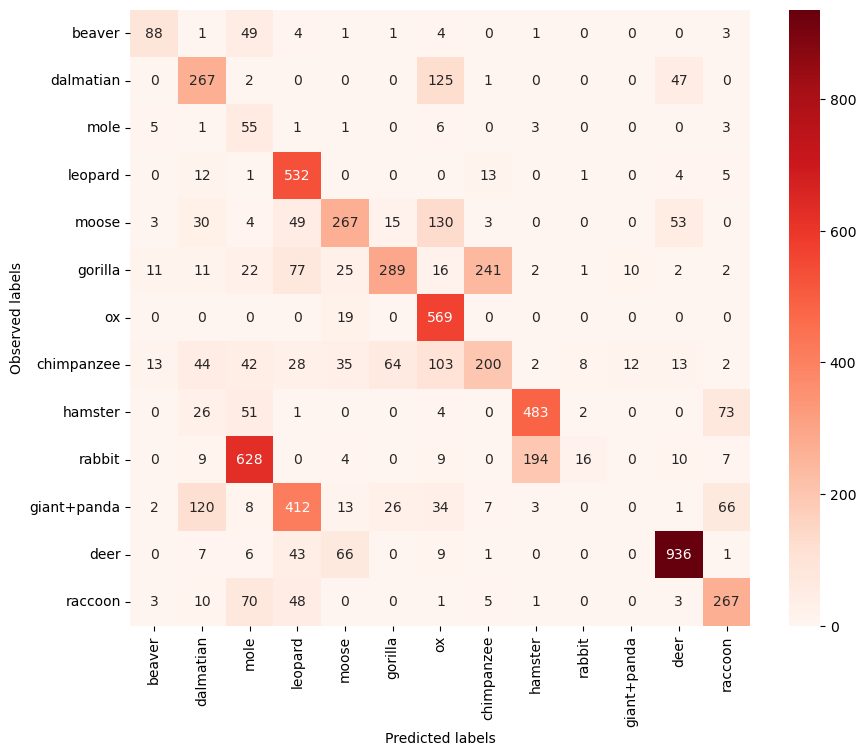

              precision    recall  f1-score   support

ARTIODACTYLA       0.82      0.93      0.87      2211
   CARNIVORA       0.80      0.82      0.81      2110
EULIPOTYPHLA       0.06      0.73      0.11        75
  LAGOMORPHA       0.57      0.02      0.04       877
    PRIMATES       0.92      0.62      0.74      1275
    RODENTIA       0.70      0.72      0.71       792

    accuracy                           0.71      7340
   macro avg       0.64      0.64      0.55      7340
weighted avg       0.78      0.71      0.71      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.92672999 0.82417062 0.73333333 0.01824401 0.6227451  0.72222222]
Top_1_accuracy for UnSeen Validation split 01 -  0.6412408783038342


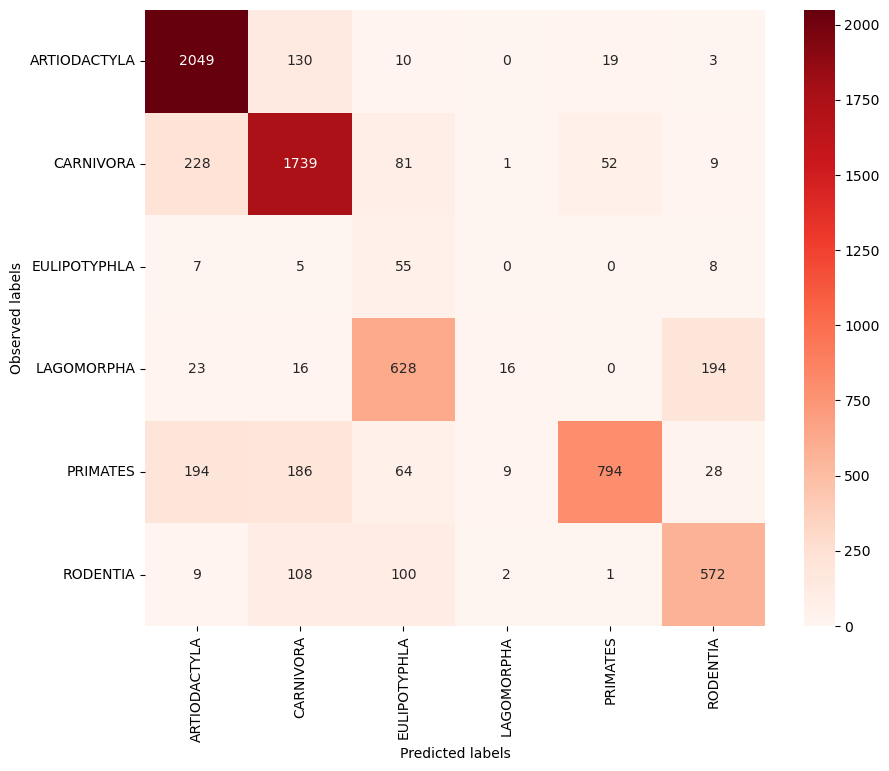

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.7096569863957367 
              0         1
0        beaver  0.690789
1     dalmatian  0.773756
2          mole  0.800000
3       leopard  0.959507
4         moose  0.788809
5       gorilla  0.722144
6            ox  1.000000
7    chimpanzee  0.565371
8       hamster  0.904687
9        rabbit  0.165336
10  giant+panda  0.002890
11         deer  0.942937
12      raccoon  0.909314 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7998170738215526 
              0         1
0        beaver  0.756579
1     dalmatian  0.893665
2          mole  0.893333
3       leopard  0.975352
4         moose  0.835740
5       gorilla  0.849083
6            ox  1.000000
7    chimpanzee  0.749117
8       hamster  0.981250
9        rabbit  0.524515
10  giant+panda  0.005780
11         deer  0.982226
12      raccoon  0.950980 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.8737398830535249 
              0         1
0        beaver  0.822368
1     

In [13]:
pred_metrics = ['Deterministic', 'Probabilistic']

for pred in pred_metrics:
    print('Using', pred, 'predictions')
    CZSL(mode = "Train", 
               split = 1, 
               DNN = ProjectionNetwork1, 
               epochs = 140, 
               bs = 44, 
               numunits = 725, 
               lr = 0.01672300858684881, 
               optimiser = nn.Sigmoid(), 
               dropout = .25897885389379416, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP1, 
               pred_type = pred, 
               dist_type = 'cosine')
    
#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

### 9.2 Train Validation Split 02

Using Deterministic predictions
Training DNN
Execution time: 146.25778937339783 seconds
Unseen Class Labels
[ 1  2  3  4  5  6 11 21 22 33 36 38 42]
TSNE spatialisation of Unseen Classes
              precision    recall  f1-score   support

    antelope       0.80      0.97      0.87       864
grizzly+bear       0.80      0.70      0.75       690
killer+whale       0.90      0.69      0.78       231
      beaver       0.42      0.07      0.12       152
   dalmatian       0.36      0.79      0.50       442
 persian+cat       0.22      0.07      0.10       599
       skunk       0.19      0.22      0.21       157
          ox       0.37      0.93      0.53       588
         fox       0.56      0.89      0.68       540
   chihuahua       0.27      0.51      0.35       448
       otter       0.75      0.01      0.01       592
       zebra       0.97      0.23      0.38       942
         pig       0.10      0.04      0.05       558

    accuracy                           0.50      6803
 

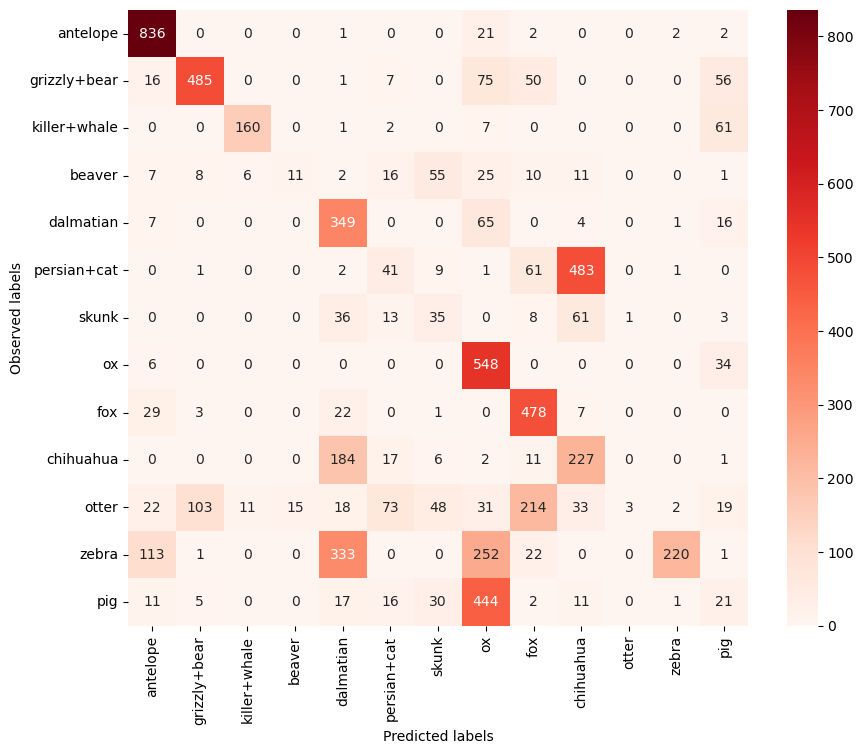

                precision    recall  f1-score   support

  ARTIODACTYLA       0.74      0.96      0.84      2241
     CARNIVORA       0.85      0.89      0.87      3468
PERISSODACTYLA       0.97      0.23      0.38       942
      RODENTIA       0.42      0.07      0.12       152

      accuracy                           0.81      6803
     macro avg       0.75      0.54      0.55      6803
  weighted avg       0.82      0.81      0.77      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.95983936 0.89244521 0.23354565 0.07236842]
Top_1_accuracy for UnSeen Validation split 01 -  0.5395496598550515


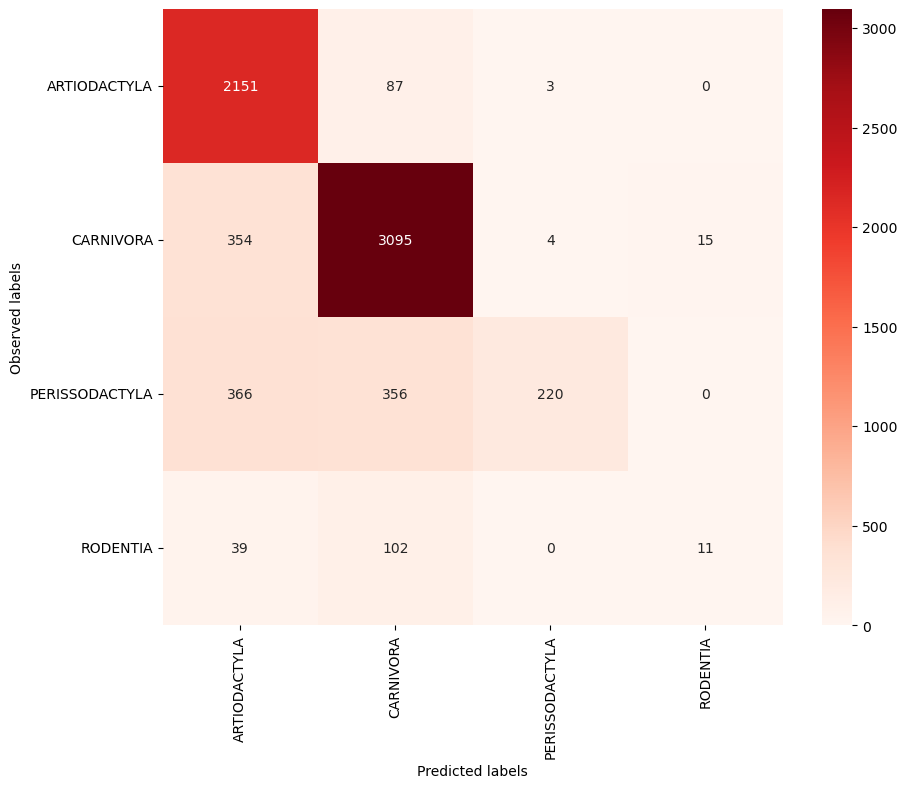

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6803439377187903 
               0         1
0       antelope  0.982639
1   grizzly+bear  0.808696
2   killer+whale  0.714286
3         beaver  0.157895
4      dalmatian  0.837104
5    persian+cat  0.555927
6          skunk  0.369427
7             ox  1.000000
8            fox  0.938889
9      chihuahua  0.919643
10         otter  0.052365
11         zebra  0.744161
12           pig  0.763441 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7609296235395386 
               0         1
0       antelope  0.997685
1   grizzly+bear  0.862319
2   killer+whale  0.731602
3         beaver  0.328947
4      dalmatian  0.959276
5    persian+cat  0.761269
6          skunk  0.490446
7             ox  1.000000
8            fox  0.961111
9      chihuahua  0.959821
10         otter  0.123311
11         zebra  0.875796
12           pig  0.840502 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.8253014299373689 
               0         1
0  

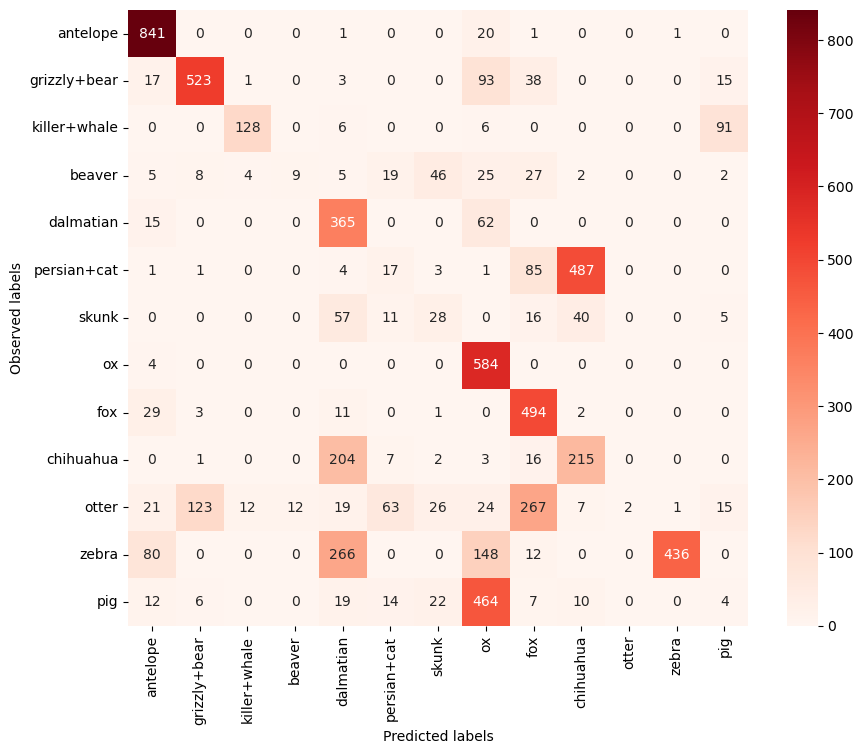

                precision    recall  f1-score   support

  ARTIODACTYLA       0.79      0.96      0.87      2241
     CARNIVORA       0.87      0.91      0.89      3468
PERISSODACTYLA       1.00      0.46      0.63       942
      RODENTIA       0.43      0.06      0.10       152

      accuracy                           0.84      6803
     macro avg       0.77      0.60      0.62      6803
  weighted avg       0.85      0.84      0.83      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.96117805 0.90570934 0.46284501 0.05921053]
Top_1_accuracy for UnSeen Validation split 01 -  0.5972357312518622


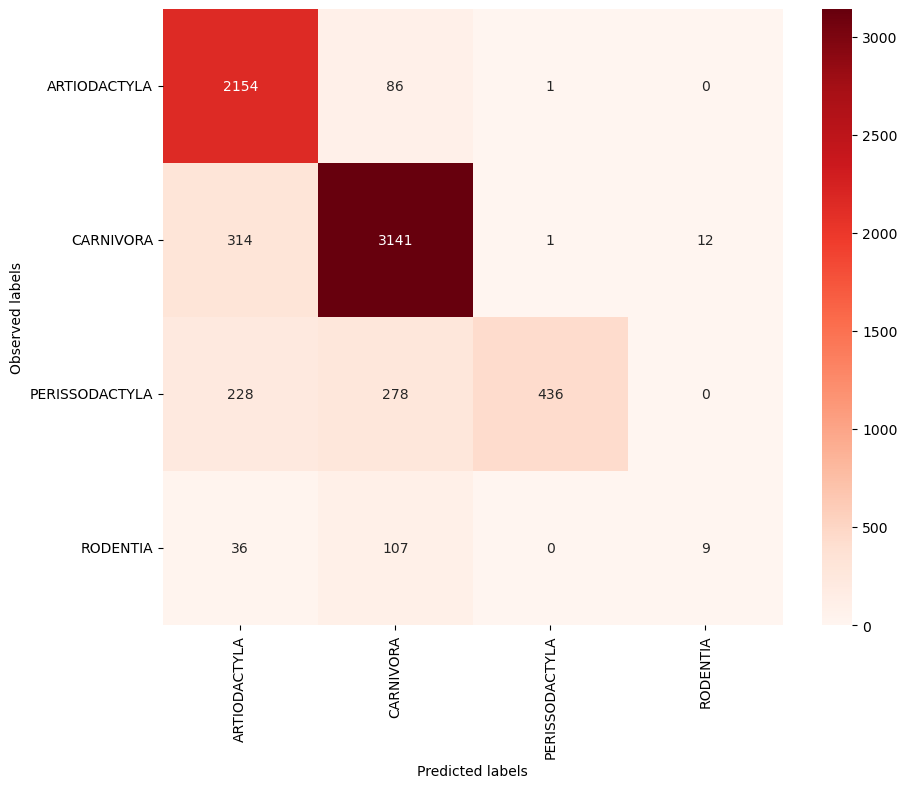

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6694912997152387 
               0         1
0       antelope  0.987269
1   grizzly+bear  0.830435
2   killer+whale  0.614719
3         beaver  0.125000
4      dalmatian  0.877828
5    persian+cat  0.410684
6          skunk  0.324841
7             ox  1.000000
8            fox  0.955556
9      chihuahua  0.877232
10         otter  0.021959
11         zebra  0.882166
12           pig  0.795699 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7677538290436614 
               0         1
0       antelope  0.998843
1   grizzly+bear  0.884058
2   killer+whale  0.735931
3         beaver  0.328947
4      dalmatian  0.963801
5    persian+cat  0.746244
6          skunk  0.503185
7             ox  1.000000
8            fox  0.981481
9      chihuahua  0.957589
10         otter  0.055743
11         zebra  0.980892
12           pig  0.844086 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.8260377638104438 
               0         1
0  

In [14]:
pred_metrics = ['Deterministic', 'Probabilistic']

for pred in pred_metrics:
    print('Using', pred, 'predictions')
    CZSL(mode = "Train", 
               split = 2, 
               DNN = ProjectionNetwork1, 
               epochs = 140, 
               bs = 44, 
               numunits = 725, 
               lr = 0.01672300858684881, 
               optimiser = nn.Sigmoid(), 
               dropout = .25897885389379416, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP2, 
               pred_type = pred, 
               dist_type = 'cosine')
    
#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

### 9.3 Train Validation Split 03

Using Deterministic predictions
Training DNN
Execution time: 154.73977613449097 seconds
Unseen Class Labels
[10 16 18 25 27 28 29 32 33 35 39 42 48]
TSNE spatialisation of Unseen Classes
                precision    recall  f1-score   support

   siamese+cat       0.39      0.80      0.52       400
         moose       0.44      0.73      0.55       554
humpback+whale       1.00      0.81      0.89       565
    chimpanzee       0.70      0.93      0.80       566
      squirrel       0.61      0.35      0.44       961
    rhinoceros       0.92      0.55      0.69       561
        rabbit       0.63      0.69      0.66       877
          wolf       0.41      0.86      0.55       470
     chihuahua       0.45      0.12      0.19       448
        weasel       0.09      0.40      0.15       222
   giant+panda       0.50      0.00      0.01       692
           pig       0.62      0.36      0.46       558
       raccoon       0.33      0.01      0.03       408

      accuracy             

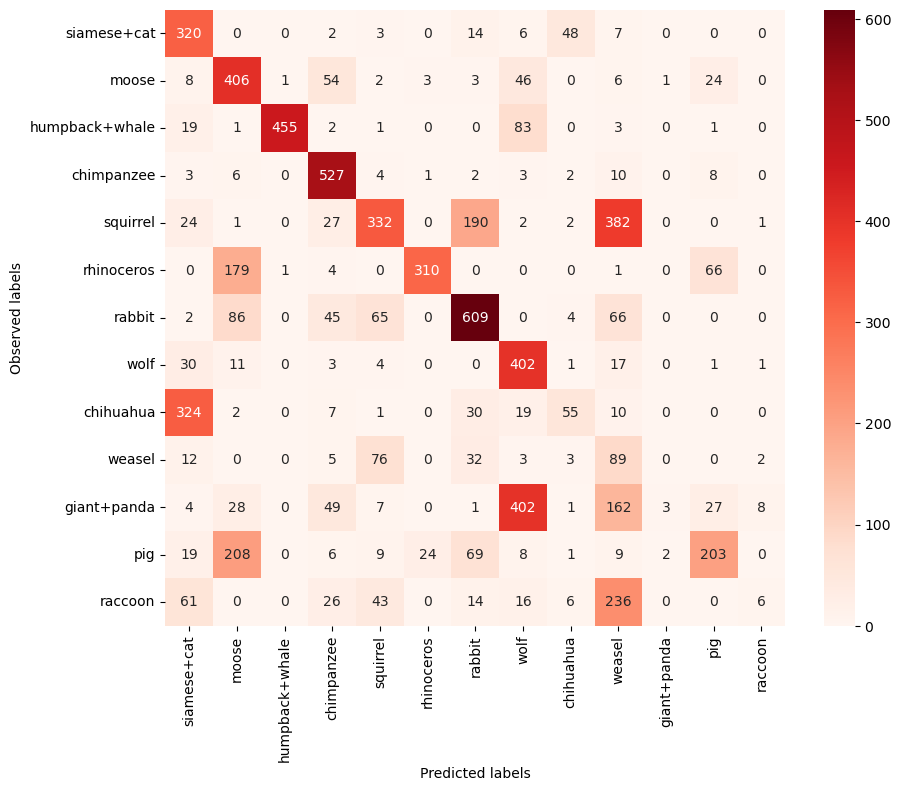

                precision    recall  f1-score   support

  ARTIODACTYLA       0.76      0.77      0.77      1677
     CARNIVORA       0.76      0.85      0.80      2640
    LAGOMORPHA       0.63      0.69      0.66       877
PERISSODACTYLA       0.92      0.55      0.69       561
      PRIMATES       0.70      0.93      0.80       566
      RODENTIA       0.61      0.35      0.44       961

      accuracy                           0.73      7282
     macro avg       0.73      0.69      0.69      7282
  weighted avg       0.73      0.73      0.72      7282

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.7745975  0.85378788 0.69441277 0.55258467 0.93109541 0.34547347]
Top_1_accuracy for UnSeen Validation split 01 -  0.691991947809636


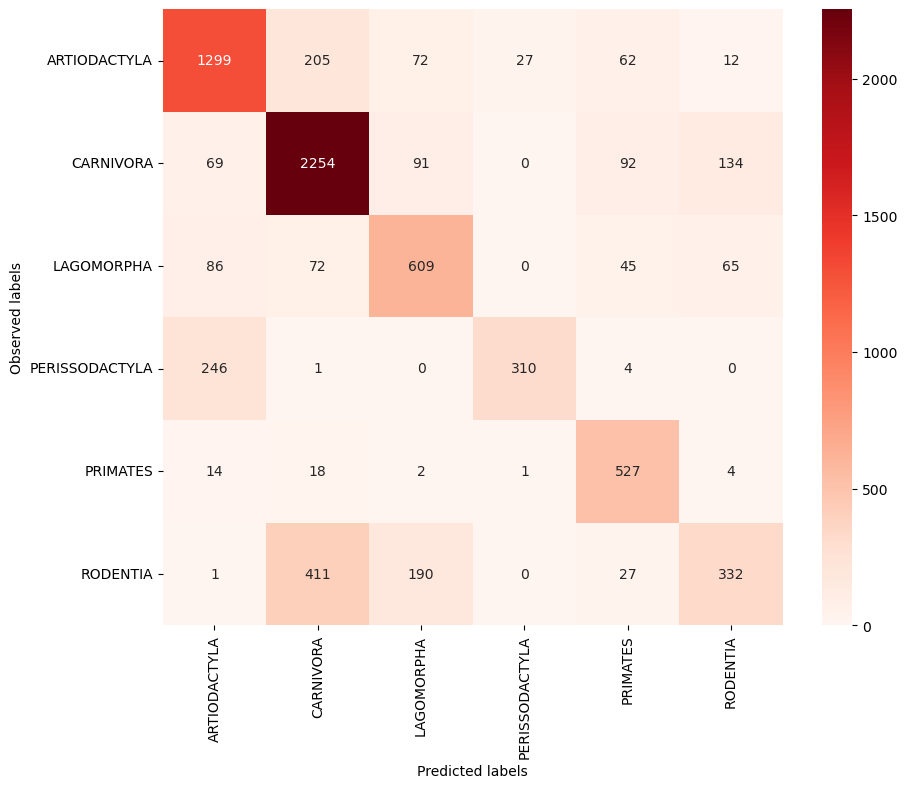

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6722443886375458 
                 0         1
0      siamese+cat  0.952500
1            moose  0.842960
2   humpback+whale  0.854867
3       chimpanzee  0.946996
4         squirrel  0.690947
5       rhinoceros  0.693405
6           rabbit  0.844926
7             wolf  0.921277
8        chihuahua  0.553571
9           weasel  0.612613
10     giant+panda  0.007225
11             pig  0.695341
12         raccoon  0.122549 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.775548884488286 
                 0         1
0      siamese+cat  0.977500
1            moose  0.879061
2   humpback+whale  0.890265
3       chimpanzee  0.973498
4         squirrel  0.796046
5       rhinoceros  0.964349
6           rabbit  0.963512
7             wolf  0.942553
8        chihuahua  0.756696
9           weasel  0.761261
10     giant+panda  0.034682
11             pig  0.811828
12         raccoon  0.330882 

 Top- 4  Accuracy per class 
 Top- 4  Accurac

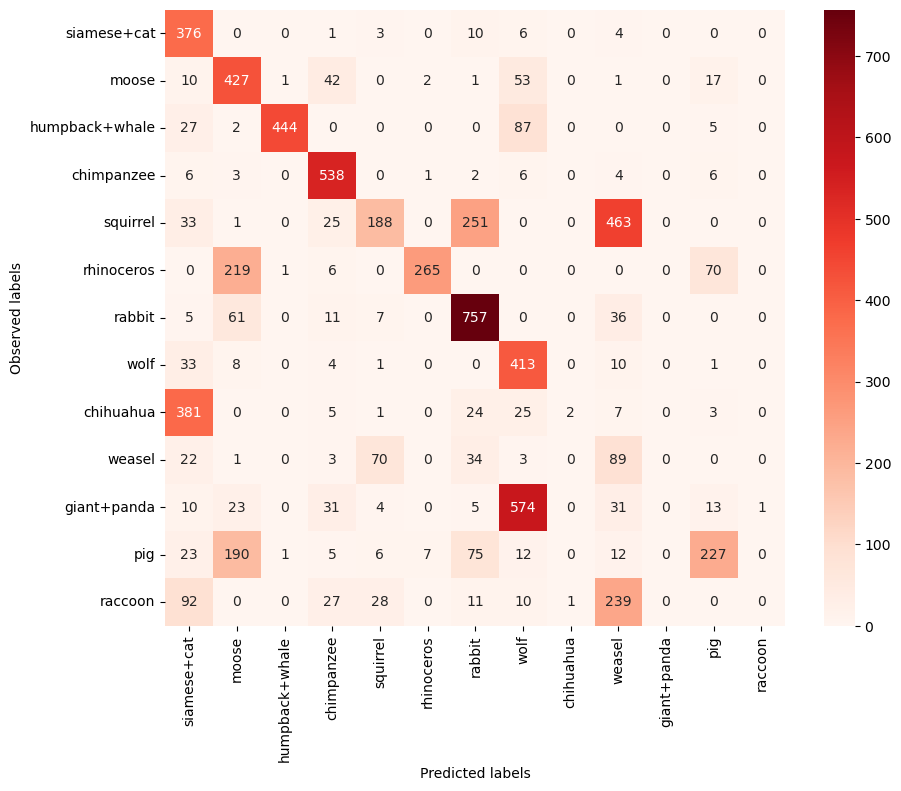

                precision    recall  f1-score   support

  ARTIODACTYLA       0.76      0.78      0.77      1677
     CARNIVORA       0.75      0.88      0.81      2640
    LAGOMORPHA       0.65      0.86      0.74       877
PERISSODACTYLA       0.96      0.47      0.63       561
      PRIMATES       0.77      0.95      0.85       566
      RODENTIA       0.61      0.20      0.30       961

      accuracy                           0.74      7282
     macro avg       0.75      0.69      0.68      7282
  weighted avg       0.74      0.74      0.71      7282

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.78354204 0.88219697 0.8631699  0.47237077 0.95053004 0.19562955]
Top_1_accuracy for UnSeen Validation split 01 -  0.6912398768006526


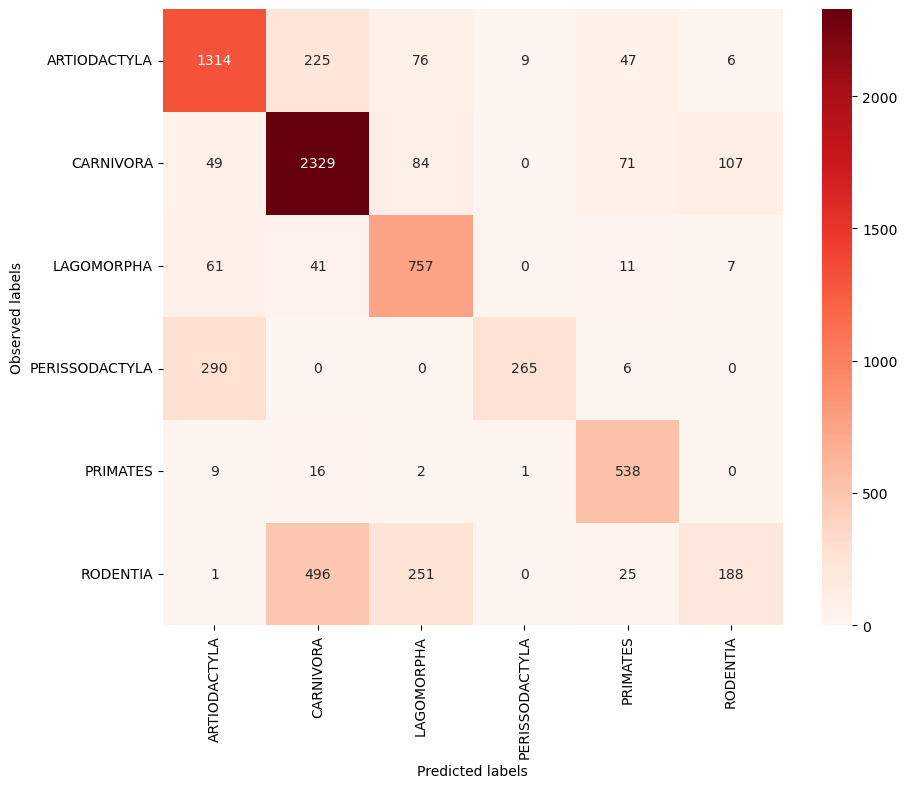

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.675249475338419 
                 0         1
0      siamese+cat  0.980000
1            moose  0.859206
2   humpback+whale  0.861947
3       chimpanzee  0.969965
4         squirrel  0.675338
5       rhinoceros  0.595365
6           rabbit  0.916762
7             wolf  0.929787
8        chihuahua  0.537946
9           weasel  0.662162
10     giant+panda  0.001445
11             pig  0.749104
12         raccoon  0.039216 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7747869577390991 
                 0         1
0      siamese+cat  0.995000
1            moose  0.880866
2   humpback+whale  0.923894
3       chimpanzee  0.980565
4         squirrel  0.824142
5       rhinoceros  0.967914
6           rabbit  0.977195
7             wolf  0.957447
8        chihuahua  0.687500
9           weasel  0.792793
10     giant+panda  0.017341
11             pig  0.802867
12         raccoon  0.264706 

 Top- 4  Accuracy per class 
 Top- 4  Accurac

In [15]:
pred_metrics = ['Deterministic', 'Probabilistic']

for pred in pred_metrics:
    print('Using', pred, 'predictions')
    CZSL(mode = "Train", 
               split = 3, 
               DNN = ProjectionNetwork1, 
               epochs = 140, 
               bs = 44, 
               numunits = 725, 
               lr = 0.01672300858684881, 
               optimiser = nn.Sigmoid(), 
               dropout = .25897885389379416, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP3, 
               pred_type = pred, 
               dist_type = 'euclidean')
    
#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

Using Deterministic predictions
Training DNN
Execution time: 196.77402186393738 seconds
Unseen Class Labels
[ 7  9 23 24 30 31 34 41 47 50]
TSNE spatialisation of Unseen Classes
              precision    recall  f1-score   support

       horse       0.29      0.48      0.36      1645
  blue+whale       0.13      0.99      0.23       174
       sheep       0.50      0.46      0.48      1420
        seal       0.60      0.25      0.36       988
         bat       0.00      0.00      0.00       383
     giraffe       0.04      0.01      0.02      1202
         rat       0.40      0.90      0.55       310
      bobcat       0.83      0.88      0.86       630
      walrus       0.14      0.07      0.09       215
     dolphin       0.62      0.17      0.27       946

    accuracy                           0.36      7913
   macro avg       0.36      0.42      0.32      7913
weighted avg       0.39      0.36      0.34      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.4

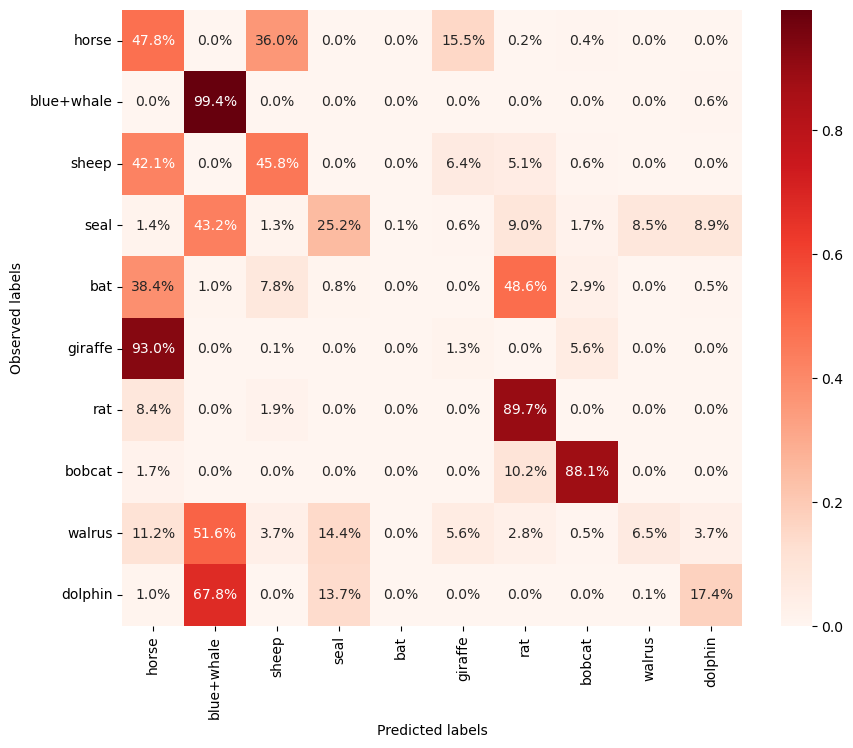

                precision    recall  f1-score   support

  ARTIODACTYLA       0.53      0.46      0.49      3742
     CARNIVORA       0.81      0.52      0.63      1833
    CHIROPTERA       0.00      0.00      0.00       383
PERISSODACTYLA       0.29      0.48      0.36      1645
      RODENTIA       0.40      0.90      0.55       310

      accuracy                           0.47      7913
     macro avg       0.40      0.47      0.41      7913
  weighted avg       0.51      0.47      0.48      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.46445751 0.5188216  0.         0.47841945 0.89677419]
Top_1_accuracy for UnSeen Validation split 01 -  0.47169455194343984


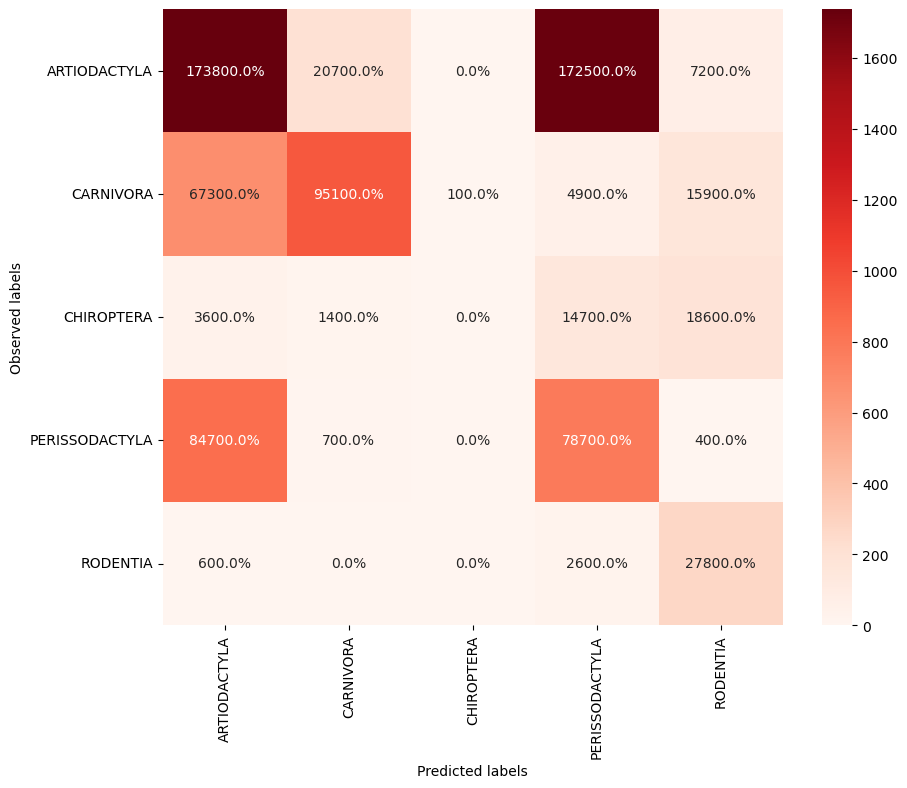

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6923980174741813 
            0         1
0       horse  0.948328
1  blue+whale  1.000000
2       sheep  0.802113
3        seal  0.472672
4         bat  0.044386
5     giraffe  0.876872
6         rat  0.958065
7      bobcat  0.980952
8      walrus  0.502326
9     dolphin  0.338266 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.805003280516366 
            0         1
0       horse  1.000000
1  blue+whale  1.000000
2       sheep  0.930986
3        seal  0.789474
4         bat  0.227154
5     giraffe  0.932612
6         rat  0.996774
7      bobcat  0.988889
8      walrus  0.641860
9     dolphin  0.542283 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.9259332034675427 
            0         1
0       horse  1.000000
1  blue+whale  1.000000
2       sheep  0.961268
3        seal  0.933198
4         bat  0.556136
5     giraffe  0.992512
6         rat  0.996774
7      bobcat  0.993651
8      walrus  0.827907
9     dolphin  0.99

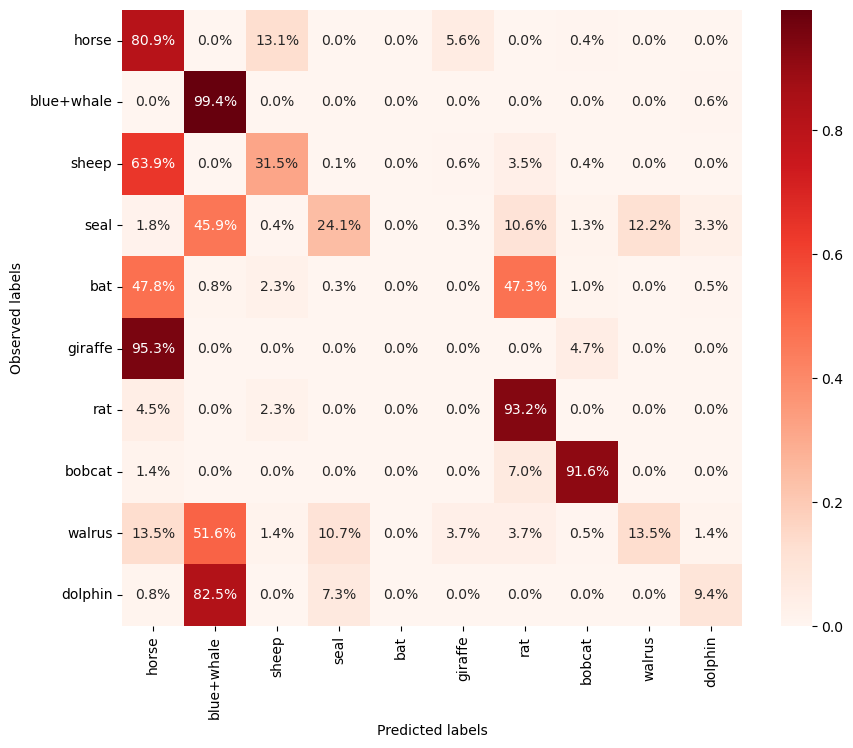

                precision    recall  f1-score   support

  ARTIODACTYLA       0.61      0.40      0.48      3742
     CARNIVORA       0.87      0.55      0.67      1833
    CHIROPTERA       0.00      0.00      0.00       383
PERISSODACTYLA       0.37      0.81      0.50      1645
      RODENTIA       0.43      0.93      0.59       310

      accuracy                           0.52      7913
     macro avg       0.46      0.54      0.45      7913
  weighted avg       0.59      0.52      0.51      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.40058792 0.54664484 0.         0.80911854 0.93225806]
Top_1_accuracy for UnSeen Validation split 01 -  0.5377218741929328


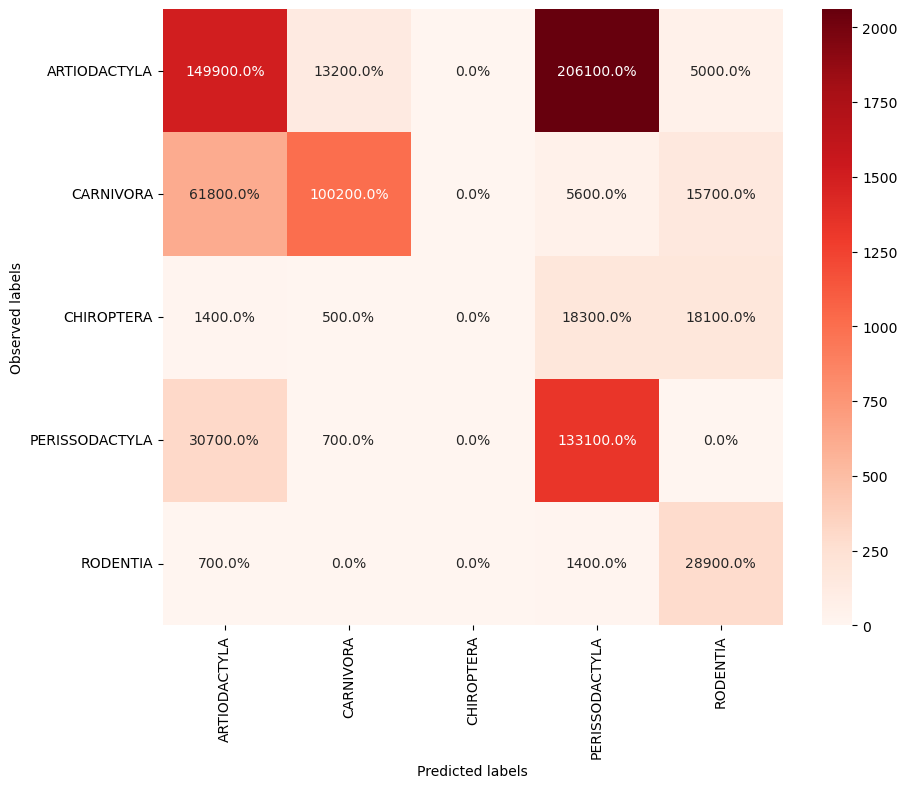

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6887907806465922 
            0         1
0       horse  0.988450
1  blue+whale  1.000000
2       sheep  0.752817
3        seal  0.466599
4         bat  0.026110
5     giraffe  0.871880
6         rat  0.970968
7      bobcat  0.985714
8      walrus  0.544186
9     dolphin  0.281184 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.8492242421847453 
            0         1
0       horse  1.000000
1  blue+whale  1.000000
2       sheep  0.935915
3        seal  0.914980
4         bat  0.177546
5     giraffe  0.950915
6         rat  1.000000
7      bobcat  0.990476
8      walrus  0.711628
9     dolphin  0.810782 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.9261938292166031 
            0         1
0       horse  1.000000
1  blue+whale  1.000000
2       sheep  0.961972
3        seal  0.972672
4         bat  0.506527
5     giraffe  0.996672
6         rat  1.000000
7      bobcat  0.993651
8      walrus  0.832558
9     dolphin  0.9

In [17]:
pred_metrics = ['Deterministic', 'Probabilistic']

for pred in pred_metrics:
    print('Using', pred, 'predictions')
    CZSL(mode = "Test", 
               split = 1, 
               DNN = ProjectionNetwork1, 
               epochs = 140, 
               bs = 44, 
               numunits = 725, 
               lr = 0.01672300858684881, 
               optimiser = nn.Sigmoid(), 
               dropout = .25897885389379416, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP_final, 
               pred_type = pred, 
               dist_type = 'cosine')
    
#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard